### General results for all cell types. 


* general counts of credible sets
* distributions of TSS-lead variant distance (TODO)
* annotation enrichments (TODO)


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re

import upsetplot as up
from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [17]:
prefix = '/home/klawren/oak/pcqtls'
tissue_df = pd.read_csv(f"{prefix}/data/references/selected_tissue_ids.csv", header=0)
tissue_ids = list(tissue_df['Tissue'])


### How many credible sets across tissues

In [18]:
def get_num_cs(susie_df):
    return len(susie_df.groupby(['phenotype_id','cs_id']))

susie_control={}
susie_pc1={}
susie_pc2={}

for tissue_id in tissue_df['Tissue']:
    susie_control[tissue_id] = pd.read_csv(f'/home/klawren/oak/pcqtls/output/control_eqtl/{tissue_id}/{tissue_id}.v8.cluster_genes.susie.txt', sep='\t', index_col=0)
    susie_pc1[tissue_id] = pd.read_csv(f'/home/klawren/oak/pcqtls/output/pcqtl/{tissue_id}/{tissue_id}.v8.pc_1.susie.txt', sep='\t', index_col=0)
    susie_pc2[tissue_id] = pd.read_csv(f'/home/klawren/oak/pcqtls/output/pcqtl/{tissue_id}/{tissue_id}.v8.pc_2.susie.txt', sep='\t', index_col=0)

In [19]:
counts = pd.DataFrame({'tissue':tissue_df['Tissue'], 
                       'num_control': [get_num_cs(susie_control[t]) for t in tissue_df['Tissue']], 
                       'num_pc1': [get_num_cs(susie_pc1[t]) for t in tissue_df['Tissue']], 
                       'num_pc2': [get_num_cs(susie_pc2[t]) for t in tissue_df['Tissue']], 
                       'num_clusters':[len(pd.read_csv(f'/home/klawren/oak/pcqtls/output/clusters_tami/{t}_clusters_all_chr.csv.txt')) for t in tissue_df['Tissue']]})


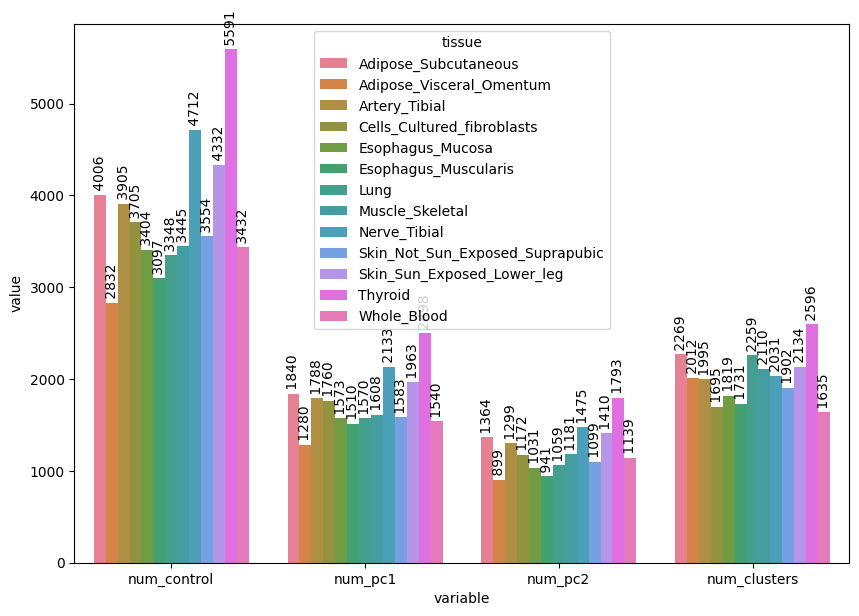

In [20]:
f, ax = plt.subplots(figsize=(10, 7))
y = sns.barplot(pd.melt(counts, id_vars=['tissue']), y='value', hue='tissue', x='variable', ax=ax)
for i in range(len(y.containers)):
    labels = [' ' + str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels, rotation=90)


In [21]:
# distribuition of distances from variant to gene tss

In [22]:
susie_control['Adipose_Subcutaneous']

,phenotype_id,variant_id,pip,af,cs_id
0,ENSG00000198744.5_ENSG00000225630.1_ENSG000002...,chr1_1543591_G_T_b38,0.968953,0.018933,1
1,ENSG00000177757.2_ENSG00000228794.8_e_ENSG0000...,chr1_775571_G_T_b38,0.008559,0.048193,1
2,ENSG00000177757.2_ENSG00000228794.8_e_ENSG0000...,chr1_777550_T_C_b38,0.012467,0.053356,1
3,ENSG00000177757.2_ENSG00000228794.8_e_ENSG0000...,chr1_777751_A_AT_b38,0.012467,0.053356,1
4,ENSG00000177757.2_ENSG00000228794.8_e_ENSG0000...,chr1_778534_A_G_b38,0.012467,0.053356,1
...,...,...,...,...,...
91833,ENSG00000188163.7_ENSG00000197768.10_ENSG00000...,chr9_137263591_T_A_b38,0.011287,0.747849,1
91834,ENSG00000188163.7_ENSG00000197768.10_ENSG00000...,chr9_137264419_T_C_b38,0.011287,0.747849,1
91835,ENSG00000188163.7_ENSG00000197768.10_ENSG00000...,chr9_137265230_G_A_b38,0.011287,0.747849,1
91836,ENSG00000188163.7_ENSG00000197768.10_ENSG00000...,chr9_137266749_T_C_b38,0.011287,0.747849,1
